In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score
import statsmodels.api as sm
import shap
from sklearn.feature_selection import SelectFromModel

from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import pymc as pm

# Load data and clean

In [30]:
df = pd.read_csv('Layoff.csv',encoding='cp1252')
df = df.drop(['Company', 'City', 'State', 'Closure/Layoff','Temporary/Permanent', 'Effective Date','Union','Region','County'], axis=1)
df['WARN Received Date'] = pd.to_datetime(df['WARN Received Date'])
df['by_month'] = df['WARN Received Date'].dt.strftime("%Y-%m")
df = df[(df.by_month<'2020-03')|(df.by_month>'2021-09')].copy()
# Check for missing values
df.isna().sum()
df.head()

,Number of Workers,WARN Received Date,Industry,Open,High,Low,Close,Volume,CPI,PPI,...,Date,Hire_quite_jolts,Job_seekers_ratio,hires_sm,quits_sm,layoffs_sm,actual_hire,log_num_of_workers,layoff_category_by_log,layoff_category_by_num
0,489.0,2020-02-26,Consumer Discretionary Select Sector SPDR Fund,123.1900,124.33000,121.18000,121.49000,12360390.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,6.192362,3,3
1,96.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.564348,3,2
2,95.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.553877,3,2
3,87.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.465908,3,2
4,75.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.317488,3,2


In [15]:
quantiles = df['Number of Workers'].quantile([0.25, 0.5, 0.75])
quantiles

0.25     15.0
0.50     52.0
0.75    100.0
Name: Number of Workers, dtype: float64

In [12]:
#df['layoff_category'] = pd.cut(df['Number of Workers'], bins=[0, quantiles.iloc[0], quantiles.iloc[1], df['Number of Workers'].max()], labels=[1,2,3])

In [31]:
# Check for missing values
#df = df[df['layoff_category'].notna()]
df.isna().sum()

Number of Workers         0
WARN Received Date        0
Industry                  0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
CPI                       0
PPI                       0
GDP                       0
unemployment_rate         0
job_nonfam                0
job_IT                    0
job_service               0
job_retail                0
job_education_health      0
fed_rate                  0
PPI_chg                   0
PPI_CPI                   0
by_month                  0
Date                      0
Hire_quite_jolts          0
Job_seekers_ratio         0
hires_sm                  0
quits_sm                  0
layoffs_sm                0
actual_hire               0
log_num_of_workers        0
layoff_category_by_log    0
layoff_category_by_num    0
dtype: int64

# Exploratory Data Analysis

array([[<AxesSubplot: title={'center': 'Number of Workers'}>,
        <AxesSubplot: title={'center': 'WARN Received Date'}>,
        <AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'High'}>,
        <AxesSubplot: title={'center': 'Low'}>],
       [<AxesSubplot: title={'center': 'Close'}>,
        <AxesSubplot: title={'center': 'Volume'}>,
        <AxesSubplot: title={'center': 'CPI'}>,
        <AxesSubplot: title={'center': 'PPI'}>,
        <AxesSubplot: title={'center': 'GDP'}>],
       [<AxesSubplot: title={'center': 'unemployment_rate'}>,
        <AxesSubplot: title={'center': 'job_nonfam'}>,
        <AxesSubplot: title={'center': 'job_IT'}>,
        <AxesSubplot: title={'center': 'job_service'}>,
        <AxesSubplot: title={'center': 'job_retail'}>],
       [<AxesSubplot: title={'center': 'job_education_health'}>,
        <AxesSubplot: title={'center': 'fed_rate'}>,
        <AxesSubplot: title={'center': 'PPI_chg'}>,
        <AxesSubplot: title={'ce

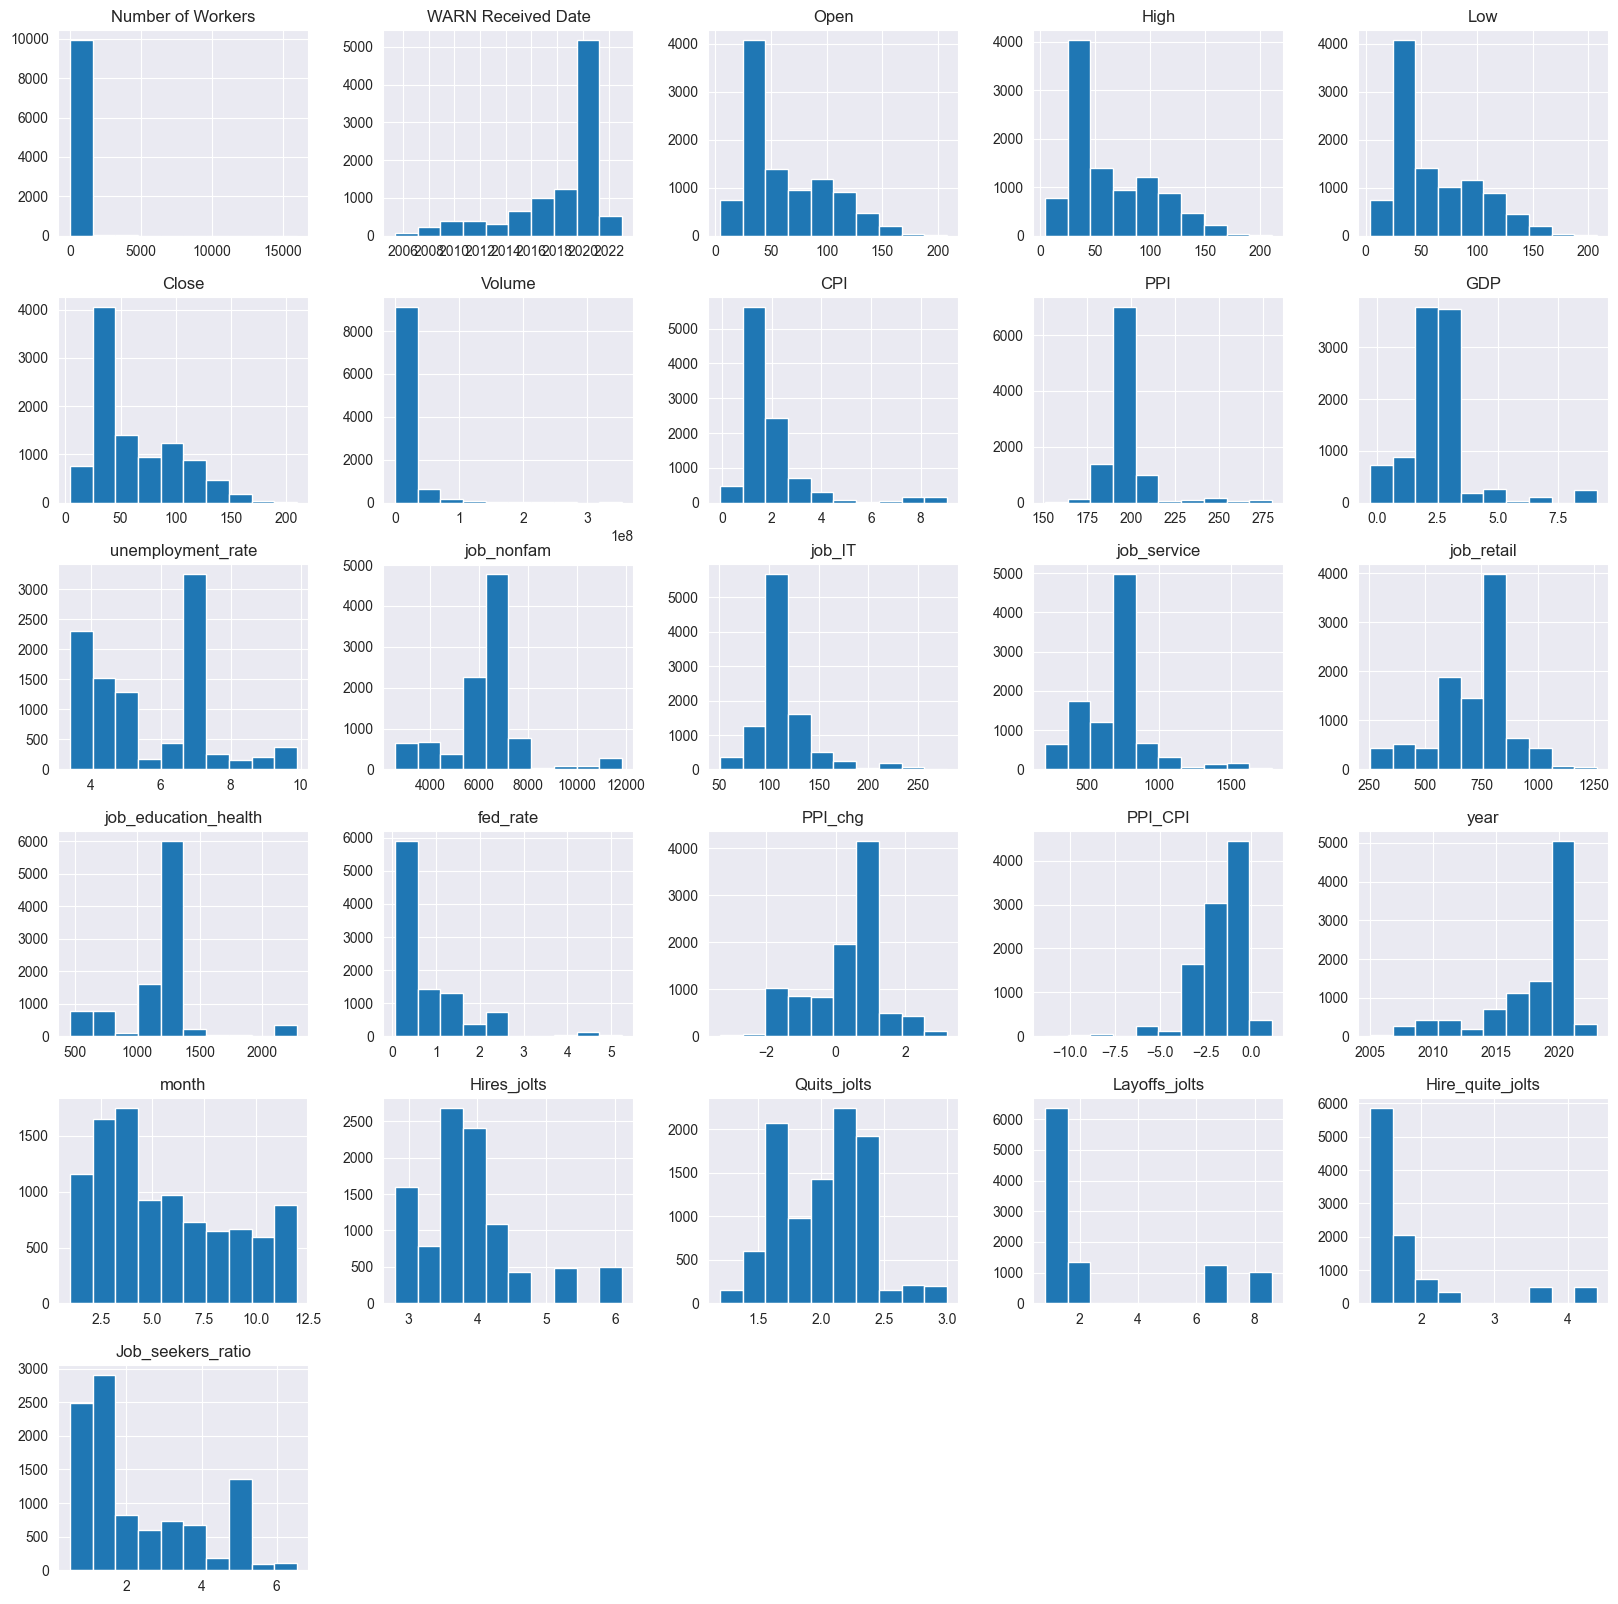

In [6]:
df.hist(figsize=(20,20))

ValueError: could not convert string to float: 'Consumer Discretionary Select Sector SPDR Fund'

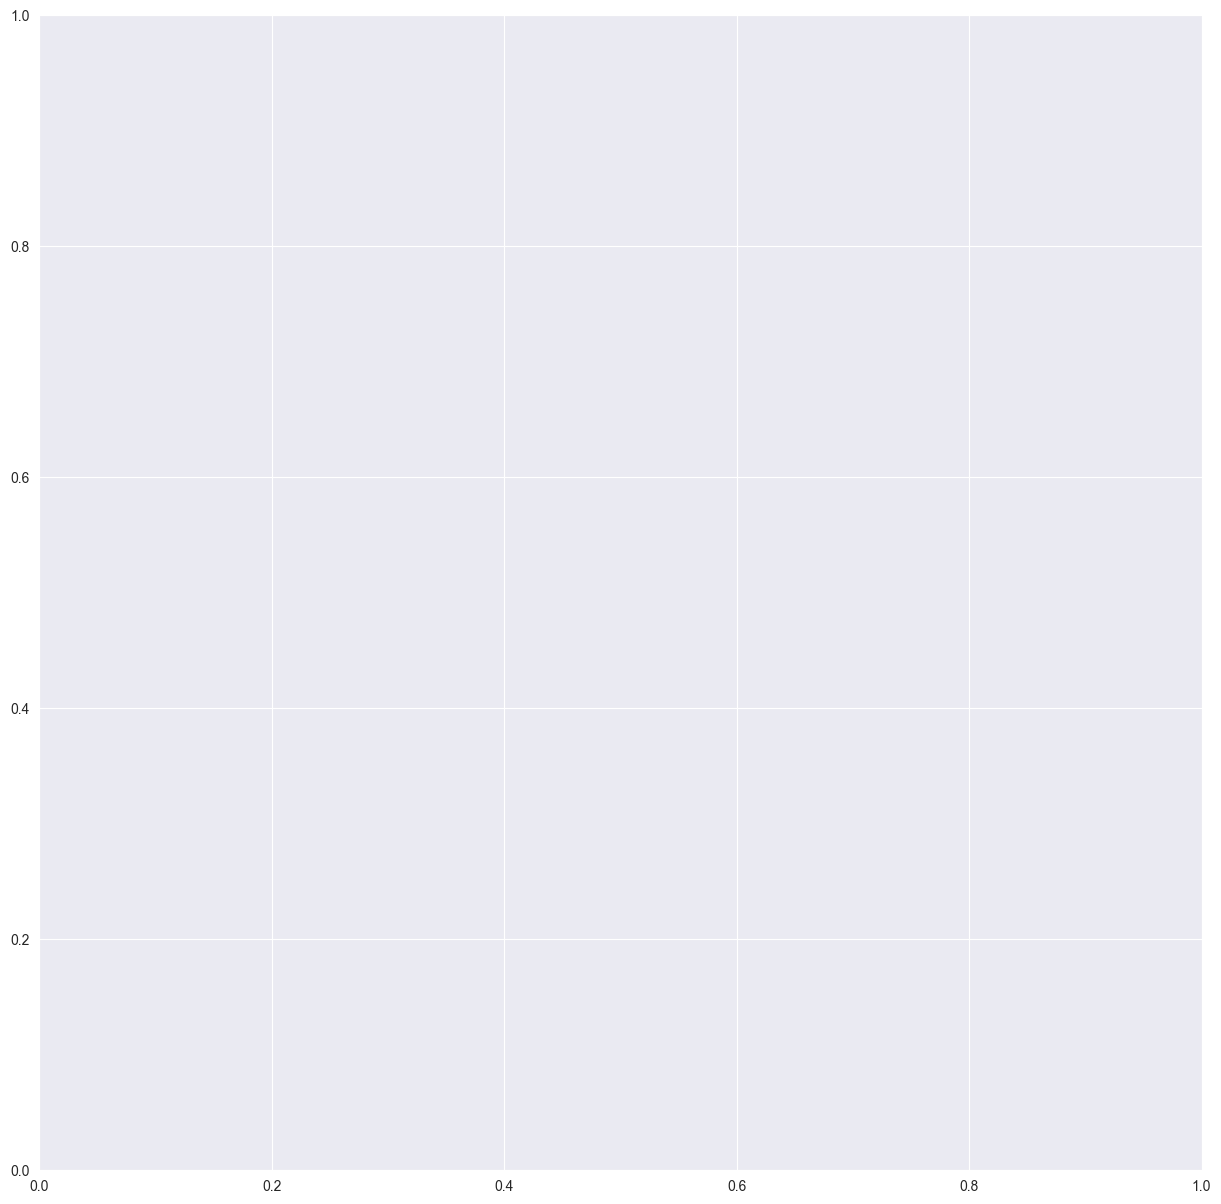

In [18]:
fig, ax = plt.subplots(figsize=(15,15))    
sns.heatmap(df.corr(), annot=True, ax=ax)

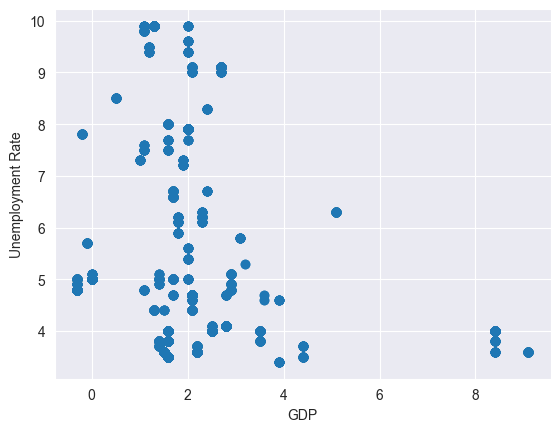

In [19]:
# Visualize the relationship between two numerical columns using a scatter plot
plt.scatter(df['GDP'], df['unemployment_rate'])
plt.xlabel('GDP')
plt.ylabel('Unemployment Rate')
plt.show()

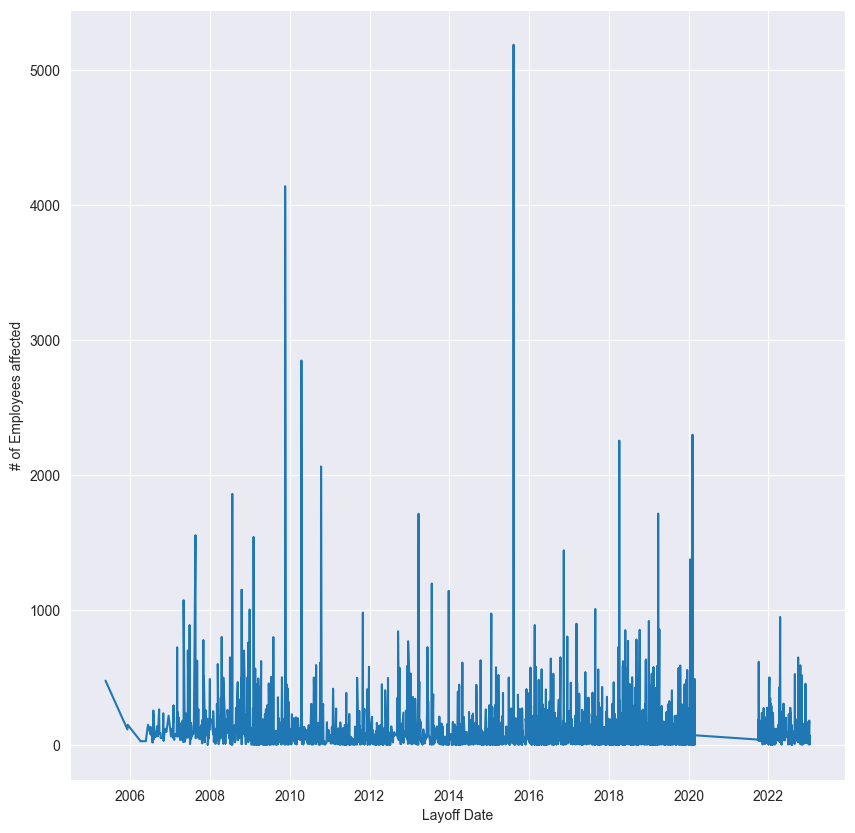

In [20]:
sortedDF = df.sort_values(by=['WARN Received Date'], ascending=True)
fig, ax = plt.subplots(figsize=(10, 10))
 
plt.plot(sortedDF['WARN Received Date'], sortedDF['Number of Workers'])
plt.xlabel('Layoff Date')
plt.ylabel('# of Employees affected')
plt.show()

# Feature Engineering


In [32]:
df['Price Volatility'] = df['High'] - df['Low']

In [33]:
# One hot encode
df = pd.get_dummies(df, columns=['Industry'])

# ML Models

In [34]:
X = df.drop(["WARN Received Date", "Number of Workers", "layoff_category_by_num", "by_month","Date"], axis=1)
y = df["layoff_category_by_num"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1707)

## MLR

In [56]:
MLR = LinearRegression().fit(X_train, y_train)
preds = MLR.predict(X_test)

In [57]:
print("R^2 : ", r2_score(y_test, preds))
print("MAE :", mean_absolute_error(y_test,preds))
print("RMSE:",np.sqrt(mean_squared_error(y_test, preds)))

R^2 :  0.6556056469258523
MAE : 0.29993126216191257
RMSE: 0.3971709697002026


## SHAP

In [16]:
#explainer = shap.Explainer(MLR.predict, X_train)
#shap_values = explainer(X_test)

DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (34,) was passed while the masker expected data of shape (35,).

In [ ]:
#shap.summary_plot(shap_values, X_test)

## MLR Ordinary Least Squares

In [55]:
#X_train = sm.add_constant(X_train) # adding a constant

model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train)

print_model = model.summary()
print(print_model)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and Open                                                       float64
High                                                       float64
Low                                                        float64
Close                                                      float64
Volume                                                     float64
CPI                                                        float64
PPI                                                        float64
GDP                                                        float64
unemployment_rate                                          float64
job_nonfam                                                   int64
job_IT                                                       int64
job_service                                                  int64
job_retail                                                   int64
job_education_health                                         int64
fed_rate                                                   float64
PPI_chg                                                    float64
PPI_CPI                                                    float64
Hire_quite_jolts                                           float64
Job_seekers_ratio                                          float64
hires_sm                                                   float64
quits_sm                                                   float64
layoffs_sm                                                 float64
actual_hire                                                float64
log_num_of_workers                                         float64
layoff_category_by_log                                       int64
Price Volatility                                           float64
Industry_Consumer Discretionary Select Sector SPDR Fund       bool
Industry_Consumer Staples Select Sector SPDR FundÂ            bool
Industry_Energy Select Sector SPDR Fund                       bool
Industry_Financial Select Sector SPDR Fund                    bool
Industry_Health Care Select Sector SPDR FundÂ                 bool
Industry_Industrial Select Sector SPDR Fund                   bool
Industry_Materials Select Sector SPDR Fund                    bool
Industry_Technology Select Sector SPDR Fund                   bool
Industry_Utilities Select Sector SPDR Fund                    bool
dtype: object. The data was
4846    2
1592    2
3556    3
542     1
3155    1
       ..
864     1
1727    3
3436    2
3774    2
3404    1
Name: layoff_category_by_num, Length: 3906, dtype: int64
and
           Open      High       Low     Close      Volume       CPI    PPI   
4846   10.5368   10.5763   10.5038   10.5434  48175559.0  1.741022  201.5  \
1592  103.9600  105.0800  103.8000  104.8800   3766806.0  1.551235  199.1   
3556   71.6000   71.8200   71.3600   71.5900   8937489.0  1.125110  183.2   
542    71.7400   72.0200   71.6100   71.9500  15061350.0  2.500042  190.7   
3155    7.5762    7.5960    7.4245    7.4509  97188430.0  2.721331  178.1   
...        ...       ...       ...       ...         ...       ...    ...   
864    81.1400   81.4610   80.9000   81.0600   7364076.0  2.074622  188.2   
1727   53.2000   53.3400   53.0800   53.3100   5705132.0  2.380612  191.5   
3436   31.4100   31.5500   31.0900   31.2500   3173076.0  5.021790  200.5   
3774   22.5500   22.7782   22.5500   22.7600   7584068.0  2.721331  178.1   
3404   52.7500   53.0300   52.6600   52.9200   8983397.0  1.594865  202.5   

      GDP  unemployment_rate  job_nonfam  ...  Price Volatility   
4846  2.0                7.9        3970  ...            0.0725  \
1592  1.6                4.0        7473  ...            1.2800   
3556  2.9                5.1        5803  ...            0.4600   
542   2.1                4.7        5617  ...            0.4100   
3155  1.3                9.9        2568  ...            0.1715   
...   ...                ...         ...  ...               ...   
864   2.1                4.7        5964  ...            0.5610   
1727  2.1                4.4        5811  ...            0.2600   
3436  2.0                5.6        3830  ...            0.4600   
3774  1.3                9.9        2568  ...            0.2282   
3404  1.6                8.0        3923  ...            0.3700   

      Industry_Consumer Discretionary Select Sector SPDR Fund   
4846                                              False        \
1592                                               True         
3556                                              False         
542                                               False         
3155                                              False         
...                                                 ...         
864                                                True         
1727                                              False         
3436                                              False         
3774                                              False         
3404                                              False         

      Industry_Consumer Staples Select Sector SPDR FundÂ    
4846                                              False    \
1592                                              False     
3556                                              False     
542                                               False     
3155                                              False     
...                                                 ...     
864                                               False     
1727                                              False     
3436                                              False     
3774                                               True     
3404                                              False     

      Industry_Energy Select Sector SPDR Fund   
4846                                    False  \
1592                                    False   
3556                                    False   
542                                     False   
3155                                    False   
...                                       ...   
864                                     False   
1727                                    False   
3436                                    False   
3774                                    False   
3404                                    False   

      Industry_Financial Select Sector SPDR Fund   
4846                                        True  \
1592                                       False   
3556                                       False   
542                                        False   
3155                                        True   
...                                          ...   
864                                        False   
1727                                       False   
3436                                       False   
3774                                       False   
3404                                       False   

      Industry_Health Care Select Sector SPDR FundÂ    
4846                                           False  \
1592                                           False   
3556                                            True   
542                                            False   
3155                                           False   
...                                              ...   
864                                            False   
1727                                           False   
3436                                            True   
3774                                           False   
3404                                            True   

      Industry_Industrial Select Sector SPDR Fund   
4846                                        False  \
1592                                        False   
3556                                        False   
542                                          True   
3155                                        False   
...                                           ...   
864                                         False   
1727                                        False   
3436                                        False   
3774                                        False   
3404                                        False   

      Industry_Materials Select Sector SPDR Fund   
4846                                       False  \
1592                                       False   
3556                                       False   
542                                        False   
3155                                       False   
...                                          ...   
864                                        False   
1727                                       False   
3436                                       False   
3774                                       False   
3404                                       False   

      Industry_Technology Select Sector SPDR Fund   
4846                                        False  \
1592                                        False   
3556                                        False   
542                                         False   
3155                                        False   
...                                           ...   
864                                         False   
1727                                         True   
3436                                        False   
3774                                        False   
3404                                        False   

      Industry_Utilities Select Sector SPDR Fund  
4846                                       False  
1592                                       False  
3556                                       False  
542                                        False  
3155                                       False  
...                                          ...  
864                                        False  
1727                                       False  
3436                                       False  
3774                                       False  
3404                                       False  

[3906 rows x 35 columns]
before. After,
[2 2 3 ... 2 2 1]
[[10.5368 10.5763 10.5038 ... False False False]
 [103.96 105.08 103.8 ... False False False]
 [71.6 71.82 71.36 ... False False False]
 ...
 [31.41 31.55 31.09 ... False False False]
 [22.55 22.7782 22.55 ... False False False]
 [52.75 53.03 52.66 ... False False False]].

## GaussianNB

In [38]:
gnb = GaussianNB()
preds = gnb.fit(X_train, y_train).predict(X_test)

In [39]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != preds).sum()))

Number of mislabeled points out of a total 977 points : 529


In [40]:
accuray = accuracy_score(preds, y_test)
f1 = f1_score(preds, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.458546571136131
F1 Score: 0.5554566890291904


## Random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier()

modelRF = SelectFromModel(rfc).fit(X_train, y_train)

X_train_newRF = modelRF.transform(X_train)
feature_names = X_train.columns[modelRF.get_support()]
X_test_newRF = X_test[feature_names]

rfc_new = RandomForestClassifier().fit(X_train_newRF, y_train)

predsRF = rfc_new.predict(X_test_newRF)

accuracy_score(predsRF, y_test)

X has feature names, but RandomForestClassifier was fitted without feature names


1.0

## Extra Trees Classifier

In [44]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

modelETC = SelectFromModel(etc).fit(X_train, y_train)

X_train_newETC = modelETC.transform(X_train)
feature_names = X_train.columns[modelETC.get_support()]
X_test_newETC = X_test[feature_names]

etc_new = ExtraTreesClassifier().fit(X_train_newETC, y_train)

predsETC = etc_new.predict(X_test_newETC)

accuracy_score(predsETC, y_test)

X has feature names, but ExtraTreesClassifier was fitted without feature names


1.0

## SGD

In [45]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, alpha=1, penalty='l1'))
preds = clf.fit(X_train, y_train).predict(X_test)

In [46]:
param_grid = {'alpha' : [.001,.01,.1,1,10,100],
              'penalty': ['l2', 'l1', 'elasticnet', None]}

gridsearch = GridSearchCV(SGDClassifier(max_iter=1000, tol=1e-3), param_grid, cv=10).fit(X_train, y_train)

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence.

In [47]:
gridsearch.best_params_

{'alpha': 100, 'penalty': 'l1'}

In [52]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, alpha=1, penalty='l1'))
preds = clf.fit(X_train, y_train).predict(X_test)

In [53]:
accuray = accuracy_score(preds, y_test)
f1 = f1_score(preds, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.4666666666666667
F1 Score: 0.6363636363636364


# Feature Selection

In [10]:
model0 = SelectFromModel(MLR, prefit=True)

In [11]:
X_train_new = model0.transform(X_train)

X has feature names, but SelectFromModel was fitted without feature names


In [12]:
feature_names = X_train.columns[model0.get_support()]

In [13]:
print('Feature Names \n',feature_names)

Feature Names 
 Index(['Open', 'GDP', 'unemployment_rate', 'year', 'Hires_jolts',
       'Layoffs_jolts', 'Hire_quite_jolts', 'Job_seekers_ratio',
       'Industry_Consumer Discretionary Select Sector SPDR Fund',
       'Industry_Energy Select Sector SPDR Fund',
       'Industry_Financial Select Sector SPDR Fund',
       'Industry_Industrial Select Sector SPDR Fund',
       'Industry_Materials Select Sector SPDR Fund',
       'Industry_Utilities Select Sector SPDR Fund'],
      dtype='object')


In [14]:
X_test_new = X_test[feature_names]

In [ ]:
X_test_new = X_test[['Open','GDP','unemployment_rate', 'year', 'Hires_jolts',
       'Layoffs_jolts', 'Hire_quite_jolts', 'Job_seekers_ratio', 'Industry_Consumer Discretionary Select Sector SPDR Fund', 'Industry_Energy Select Sector SPDR Fund','Industry_Financial Select Sector SPDR Fund','Industry_Industrial Select Sector SPDR Fund','Industry_Materials Select Sector SPDR Fund','Industry_Utilities Select Sector SPDR Fund']]

In [17]:
MLR0 = LinearRegression().fit(X_train_new, y_train)
preds = MLR0.predict(X_test_new)

X has feature names, but LinearRegression was fitted without feature names


In [42]:
preds = np.round(preds)

array([2., 2., 2., ..., 2., 2., 2.])

In [30]:
y_test = y_test.cat.codes.astype(np.float64)

In [41]:
accuracy_score(preds,y_test)

0.3107769423558897

# Kernel SVM

In [49]:
kernel_svm_model = SVC(kernel="rbf")

#Fit the Kernel SVM model on the training data
kernel_svm_model.fit(X_train, y_train)

#Display summary of the Kernel SVM model
print(kernel_svm_model)

#Predict on the training data using the Kernel SVM model
kernel_svm_model_predicted_training = kernel_svm_model.predict(X_train)

#Predict on the test data using the Kernel SVM model
kernel_svm_model_predicted_test = kernel_svm_model.predict(X_test)



SVC()


In [50]:
# Accuracy
kernel_svm_model_training_accuracy = metrics.accuracy_score(y_train, kernel_svm_model_predicted_training)
kernel_svm_model_test_accuracy = metrics.accuracy_score(y_test, kernel_svm_model_predicted_test)

print('Training Accuracy: ' + str(kernel_svm_model_training_accuracy))
print('Test Accuracy: ' + str(kernel_svm_model_test_accuracy))

#Summarize the fit of the Kernel SVM model on the training data
print(metrics.classification_report(y_train, kernel_svm_model_predicted_training))
print(metrics.confusion_matrix(y_train, kernel_svm_model_predicted_training))

#Summarize the fit of the Kernel SVM model on the test data
print(metrics.classification_report(y_test, kernel_svm_model_predicted_test))
print(metrics.confusion_matrix(y_test, kernel_svm_model_predicted_test))

Training Accuracy: 0.48899129544290837
Test Accuracy: 0.46059365404298874
              precision    recall  f1-score   support

           1       0.49      0.99      0.66      1900
           2       0.53      0.01      0.02      1571
           3       0.44      0.01      0.02       435

    accuracy                           0.49      3906
   macro avg       0.49      0.34      0.23      3906
weighted avg       0.50      0.49      0.33      3906

[[1889    9    2]
 [1551   17    3]
 [ 425    6    4]]
              precision    recall  f1-score   support

           1       0.46      0.99      0.63       447
           2       0.53      0.02      0.04       416
           3       0.00      0.00      0.00       114

    accuracy                           0.46       977
   macro avg       0.33      0.34      0.22       977
weighted avg       0.44      0.46      0.30       977

[[442   4   1]
 [406   8   2]
 [111   3   0]]


# Neural Net

In [53]:
neural_network_model = MLPClassifier(alpha=1, hidden_layer_sizes = (20, 10))

#Fit the simple neural network model on the training data
neural_network_model.fit(X_train, y_train)

#Display summary of the simple neural network model
print(neural_network_model)

#Predict on the training data using the simple neural network model
neural_network_model_predicted_training  = neural_network_model.predict(X_train)

#Predict on the test data using the simple neural network model
neural_network_model_predicted_test = neural_network_model.predict(X_test)



MLPClassifier(alpha=1, hidden_layer_sizes=(20, 10))


In [54]:
#Accuracy
neural_network_model_training_accuracy = metrics.accuracy_score(y_train, neural_network_model_predicted_training)
neural_network_model_test_accuracy = metrics.accuracy_score(y_test, neural_network_model_predicted_test)

print('Training Accuracy: ' + str(neural_network_model_training_accuracy))
print('Test Accuracy: ' + str(neural_network_model_test_accuracy))

#Summarize the fit of the simple neural network model on the training data
print(metrics.classification_report(y_train, neural_network_model_predicted_training))
print(metrics.confusion_matrix(y_train, neural_network_model_predicted_training))

#Summarize the fit of the simple neural network model on the test data
print(metrics.classification_report(y_test, neural_network_model_predicted_test))
print(metrics.confusion_matrix(y_test, neural_network_model_predicted_test))

Training Accuracy: 0.4324116743471582
Test Accuracy: 0.4083930399181167
              precision    recall  f1-score   support

           1       0.49      0.83      0.62      1900
           2       0.40      0.03      0.06      1571
           3       0.09      0.11      0.10       435

    accuracy                           0.43      3906
   macro avg       0.33      0.33      0.26      3906
weighted avg       0.41      0.43      0.34      3906

[[1586   68  246]
 [1259   53  259]
 [ 373   12   50]]
              precision    recall  f1-score   support

           1       0.45      0.82      0.58       447
           2       0.48      0.05      0.09       416
           3       0.11      0.12      0.11       114

    accuracy                           0.41       977
   macro avg       0.35      0.33      0.26       977
weighted avg       0.42      0.41      0.32       977

[[365  17  65]
 [343  20  53]
 [ 95   5  14]]
